In [268]:
import numpy as np
import matplotlib.pyplot as plt

In [269]:
rng = np.random.default_rng(12345)

# Initialize Constants

In [270]:
NUM_DAYS_TOTAL = 5000
SOIL_POROSITY = 0.4
SOIL_DEPTH_MM = 800
HYGROSCOPIC_POINT = 0.02
WILTING_POINT = 0.065
MAX_MOISTURE_WITH_CLOSED_STOMATA = 0.17
FIELD_CAPACITY = 0.3
MAXIMUM_EVAPORATION_RATE_MM_PER_DAY = 1.0
MAXIMUM_TRANSPIRATION_RATE_MM_PER_DAY = 3.5
SATURATED_HYDRAULIC_CONDUCTIVITY_MM_PER_DAY = 1100
PORE_SIZE_DISTRIBUTION_INDEX = 4.05
BETA = 4.0 * PORE_SIZE_DISTRIBUTION_INDEX + 4.0
ADDED_RESIDUE_CARBON_G_PER_M2_PER_DAY = 1.5
PROPORTION_BIOMASS_DYING_PER_DAY = 0.0085
PROPORTION_LITTER_DECOMPOSING_PER_BIOMASS_PER_DAY = 0.000065
PROPORTION_HUMUS_DECOMPOSING_PER_BIOMASS_PER_DAY = 0.0000025
MAX_PROPORTION_AMMONIUM_IMMOBILIZED_PER_DAY = 1.0
MAX_PROPORTION_NITRATE_IMMOBILIZED_PER_DAY = 1.0
PROPORTION_AMMONIUM_NITRIFIED_PER_BIOMASS_PER_DAY = 0.6
DISSOLVED_FRACTION_AMMONIUM = 0.05
DISSOLVED_FRACTION_NITRATE = 1.0
RESPIRATED_FRACTION_OF_DECOMPOSED_CARBON = 0.6
NON_RESPIRATED_FRACTION_OF_DECOMPOSED_CARBON = 1- RESPIRATED_FRACTION_OF_DECOMPOSED_CARBON
MAX_HUMIFIED_FRACTION_OF_DECOMPOSED_LITTER = 0.25
ADDED_RESIDUE_CN_RATIO = 58
BIOMASS_CN_RATIO = 11.5
HUMUS_CN_RATIO = 22 # porporato had 22
PLANT_AMMONIUM_DEMAND_GRAMS_N_PER_M3_PER_DAY = 0.2
PLANT_NITRATE_DEMAND_GRAMS_N_PER_M3_PER_DAY = 0.5
DIFFUSION_COEFFICIENT_MM_PER_DAY = 100 # possibly should be 100 ? Porporato has 0.1 meters/day
DIFFUSION_MOISTURE_DEPENDENCE_EXPONENT = 3
RAIN_EXISTENCE_RATE = 0.23
RAIN_MEAN_DEPTH_MM = 11 # porporato had 11

# States

In [271]:
soil_moisture = np.zeros(NUM_DAYS_TOTAL)
litter_carbon_g_per_m3 = np.zeros(NUM_DAYS_TOTAL)
biomass_carbon_g_per_m3 = np.zeros(NUM_DAYS_TOTAL)
humus_carbon_g_per_m3 = np.zeros(NUM_DAYS_TOTAL)
litter_nitrogen_g_per_m3 = np.zeros(NUM_DAYS_TOTAL)
ammonium_nitrogen_g_per_m3 = np.zeros(NUM_DAYS_TOTAL)
nitrate_nitrogen_g_per_m3 = np.zeros(NUM_DAYS_TOTAL)

# fake states
biomass_nitrogen_g_per_m3 = np.zeros(NUM_DAYS_TOTAL)
humus_nitrogen_g_per_m3 = np.zeros(NUM_DAYS_TOTAL)

# Step Intermediate Variables

In [272]:
rain_events = np.zeros(NUM_DAYS_TOTAL)
rain_quantity_mm = np.zeros(NUM_DAYS_TOTAL)
infiltration_rate_mm_per_day = np.zeros(NUM_DAYS_TOTAL)
evaporation_rate_mm_per_day = np.zeros(NUM_DAYS_TOTAL)
transpiration_rate_mm_per_day = np.zeros(NUM_DAYS_TOTAL)
leakage_rate_mm_per_day = np.zeros(NUM_DAYS_TOTAL)
volume_water_per_unit_area_mm = np.zeros(NUM_DAYS_TOTAL)
moisture_effect_on_decomposition_factor = np.zeros(NUM_DAYS_TOTAL)
moisture_effect_on_nitrification_factor = np.zeros(NUM_DAYS_TOTAL)
max_active_ammonium_uptake_proportion_per_day = np.zeros(NUM_DAYS_TOTAL)
max_active_nitrate_uptake_proportion_per_day = np.zeros(NUM_DAYS_TOTAL)
litter_cn_ratio = np.zeros(NUM_DAYS_TOTAL)
humified_fraction_of_decomposed_litter = np.zeros(NUM_DAYS_TOTAL)
biomassified_fraction_of_decomposed_litter_carbon = np.zeros(NUM_DAYS_TOTAL)
available_mineral_nitrogen_g_per_m3_per_day = np.zeros(NUM_DAYS_TOTAL)
maximum_immobilization_rate_g_N_per_m3_per_day = np.zeros(NUM_DAYS_TOTAL)
surplus_N_at_max_decomposition_rate_g_N_per_biomass_per_day_per_m3 = np.zeros(NUM_DAYS_TOTAL) # i.e. the surplus N beyond what is needed to maintain the C/N ratios of the biomass and humus pools. If this is positive, mineralization occurs; if it is negative, immobilization occurs
immobilization_demand_g_N_per_m3_per_day = np.zeros(NUM_DAYS_TOTAL)
phi = np.zeros(NUM_DAYS_TOTAL)
net_flux_to_mineralized_nitrogen_g_per_m3_per_day = np.zeros(NUM_DAYS_TOTAL)
total_immobilization_rate_g_N_per_m3_per_day = np.zeros(NUM_DAYS_TOTAL)
plant_passive_ammonium_uptake_rate_g_N_per_m3_per_day = np.zeros(NUM_DAYS_TOTAL)
plant_passive_nitrate_uptake_rate_g_N_per_m3_per_day = np.zeros(NUM_DAYS_TOTAL)
max_active_ammonium_uptake_g_N_per_m3_per_day = np.zeros(NUM_DAYS_TOTAL)
max_active_nitrate_uptake_g_N_per_m3_per_day = np.zeros(NUM_DAYS_TOTAL)
plant_active_ammonium_uptake_rate_g_N_per_m3_per_day = np.zeros(NUM_DAYS_TOTAL)
plant_active_nitrate_uptake_rate_g_N_per_m3_per_day = np.zeros(NUM_DAYS_TOTAL)

# Flows

In [273]:
added_residues_g_C_per_m3_per_day = np.zeros(NUM_DAYS_TOTAL)
biomass_death_rate_g_carbon_per_m3_per_day = np.zeros(NUM_DAYS_TOTAL)
litter_decomposition_rate_g_carbon_per_m3_per_day = np.zeros(NUM_DAYS_TOTAL)
humus_decomposition_rate_g_carbon_per_m3_per_day = np.zeros(NUM_DAYS_TOTAL)
mineralization_rate_g_N_per_m3_per_day = np.zeros(NUM_DAYS_TOTAL)
ammonium_immobilization_rate_g_N_per_m3_per_day = np.zeros(NUM_DAYS_TOTAL)
nitrate_immobilization_rate_g_N_per_m3_per_day = np.zeros(NUM_DAYS_TOTAL)
nitrification_rate_g_N_per_m3_per_day = np.zeros(NUM_DAYS_TOTAL)
ammonium_leaching_rate_g_N_per_m3_per_day = np.zeros(NUM_DAYS_TOTAL)
nitrate_leaching_rate_g_N_per_m3_per_day = np.zeros(NUM_DAYS_TOTAL)
ammonium_uptake_rate_g_N_per_m3_per_day = np.zeros(NUM_DAYS_TOTAL)
nitrate_uptake_rate_g_N_per_m3_per_day = np.zeros(NUM_DAYS_TOTAL)

# Initial Conditions

In [274]:
soil_moisture[0] = 0.15
litter_carbon_g_per_m3[0] = 1300
biomass_carbon_g_per_m3[0] = 50
humus_carbon_g_per_m3[0] = 8500
litter_nitrogen_g_per_m3[0] = litter_carbon_g_per_m3[0] / 34.0 # porporato had 34
# ammonium_nitrogen_g_per_m3[0] = 28.025 # equivalent to 200 lbs/acre of N
ammonium_nitrogen_g_per_m3[0] = 0.1
nitrate_nitrogen_g_per_m3[0] = 1.0 # porporato had <= 1.0

biomass_nitrogen_g_per_m3[0] = biomass_carbon_g_per_m3[0] / BIOMASS_CN_RATIO
humus_nitrogen_g_per_m3[0] = humus_carbon_g_per_m3[0] / HUMUS_CN_RATIO


# Rainfall

<BarContainer object of 5000 artists>

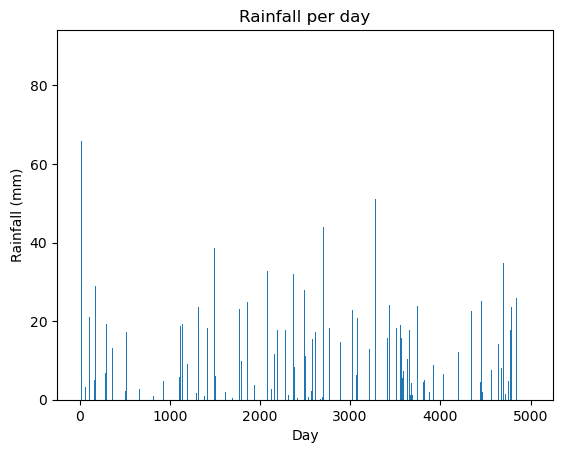

In [275]:
rain_events = rng.random(rain_events.shape) < RAIN_EXISTENCE_RATE
rain_quantity_mm = rng.exponential(RAIN_MEAN_DEPTH_MM, rain_quantity_mm.shape) * rain_events
plt.title("Rainfall per day")
plt.xlabel("Day")
plt.ylabel("Rainfall (mm)")
plt.bar(range(NUM_DAYS_TOTAL), rain_quantity_mm)

# Water Modeling

In [276]:
for i in range(NUM_DAYS_TOTAL):
    infiltration_rate_mm_per_day[i] = min(rain_quantity_mm[i], SOIL_POROSITY * SOIL_DEPTH_MM * (1 - soil_moisture[i]))

    # evaporation
    if soil_moisture[i] < HYGROSCOPIC_POINT:
        evaporation_rate_mm_per_day[i] = 0
    elif soil_moisture[i] <= WILTING_POINT:
        evaporation_rate_mm_per_day[i] = MAXIMUM_EVAPORATION_RATE_MM_PER_DAY * (soil_moisture[i] - HYGROSCOPIC_POINT)
    else:
        evaporation_rate_mm_per_day[i] = MAXIMUM_EVAPORATION_RATE_MM_PER_DAY

    # Transpiration
    if soil_moisture[i] <= WILTING_POINT:
        transpiration_rate_mm_per_day[i] = 0
    elif soil_moisture[i] <= MAX_MOISTURE_WITH_CLOSED_STOMATA:
        transpiration_rate_mm_per_day[i] = MAXIMUM_TRANSPIRATION_RATE_MM_PER_DAY * (soil_moisture[i] - WILTING_POINT) / (MAX_MOISTURE_WITH_CLOSED_STOMATA - WILTING_POINT)
    else:
        transpiration_rate_mm_per_day[i] = MAXIMUM_TRANSPIRATION_RATE_MM_PER_DAY

    # leakage/percolation
    leakage_rate_mm_per_day[i] = SATURATED_HYDRAULIC_CONDUCTIVITY_MM_PER_DAY * (np.exp(BETA * (soil_moisture[i] - FIELD_CAPACITY)) - 1) / (np.exp(BETA * (1 - FIELD_CAPACITY)) - 1)

    if i + 1 < NUM_DAYS_TOTAL:
        soil_moisture[i+1] = soil_moisture[i] + (infiltration_rate_mm_per_day[i] - evaporation_rate_mm_per_day[i] - transpiration_rate_mm_per_day[i] - leakage_rate_mm_per_day[i]) / (SOIL_POROSITY * SOIL_DEPTH_MM)


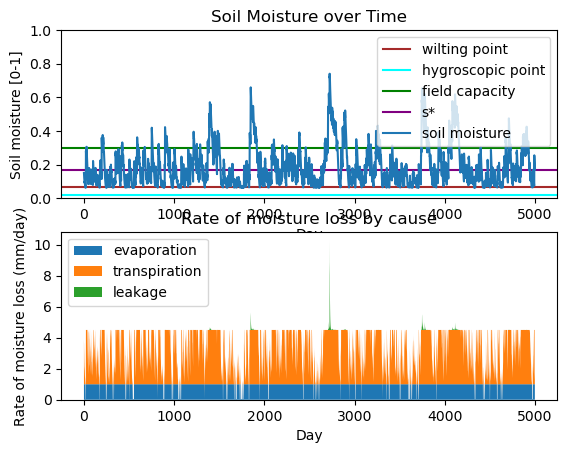

In [282]:
plt.figure()
ax = plt.subplot(2, 1, 1)
plt.title("Soil Moisture over Time")
plt.xlabel("Day")
plt.ylabel("Soil moisture [0-1]")
plt.ylim(0,1)
plt.axhline(y=WILTING_POINT, label="wilting point", color="brown")
plt.axhline(y=HYGROSCOPIC_POINT, label="hygroscopic point", color="cyan")
plt.axhline(y=FIELD_CAPACITY, label="field capacity", color="green")
plt.axhline(y=MAX_MOISTURE_WITH_CLOSED_STOMATA, label="s*", color="purple")
plt.plot(range(NUM_DAYS_TOTAL), soil_moisture, label="soil moisture")
plt.legend(loc="upper right")

plt.subplot(2, 1, 2, sharex=ax)
plt.stackplot(range(NUM_DAYS_TOTAL), evaporation_rate_mm_per_day, transpiration_rate_mm_per_day, leakage_rate_mm_per_day, baseline="zero", labels = ["evaporation", "transpiration", "leakage"])
plt.title("Rate of moisture loss by cause")
plt.xlabel("Day")
plt.ylabel("Rate of moisture loss (mm/day)")
plt.legend(loc="upper left")

In [278]:
volume_water_per_unit_area_mm = soil_moisture * SOIL_DEPTH_MM * SOIL_POROSITY
f_d = np.vectorize(lambda s : s / FIELD_CAPACITY if s <= FIELD_CAPACITY else FIELD_CAPACITY / s)
moisture_effect_on_decomposition_factor = f_d(soil_moisture)
f_n = np.vectorize(lambda s: s / FIELD_CAPACITY if s <= FIELD_CAPACITY else (1 - s)/(1- FIELD_CAPACITY))
moisture_effect_on_nitrification_factor = f_n(soil_moisture)
max_active_ammonium_uptake_proportion_per_day = DISSOLVED_FRACTION_AMMONIUM * DIFFUSION_COEFFICIENT_MM_PER_DAY / volume_water_per_unit_area_mm * (soil_moisture ** DIFFUSION_MOISTURE_DEPENDENCE_EXPONENT)
max_active_nitrate_uptake_proportion_per_day = DISSOLVED_FRACTION_NITRATE * DIFFUSION_COEFFICIENT_MM_PER_DAY / volume_water_per_unit_area_mm * (soil_moisture ** DIFFUSION_MOISTURE_DEPENDENCE_EXPONENT)

if not np.all([moisture_effect_on_decomposition_factor <= 1.0, moisture_effect_on_decomposition_factor >= 0.0, moisture_effect_on_nitrification_factor <= 1.0, moisture_effect_on_nitrification_factor >= 0.0]):
    print("out of range!")

In [279]:
def print_step(i):
    print("Litter C state (gC/m^3):\t\t", litter_carbon_g_per_m3[i])
    print("Litter N state (gN/m^3):\t\t", litter_nitrogen_g_per_m3[i])
    print("Litter C/N Ratio:\t\t", litter_cn_ratio[i])
    print("Humified fraction of decomposed litter [0,1]:\t\t", humified_fraction_of_decomposed_litter[i])
    print("Ammonium state (gN/m^3):\t\t", ammonium_nitrogen_g_per_m3[i])
    print("Nitrate state (gN/m^3):\t\t", nitrate_nitrogen_g_per_m3[i])
    print("Humus C state (gC/m^3):\t\t", humus_carbon_g_per_m3[i])
    print("phi [0,1]:\t\t", phi[i])


# Soil C/N Dynamics

In [280]:
for i in range(NUM_DAYS_TOTAL):
    litter_cn_ratio[i] = litter_carbon_g_per_m3[i] / litter_nitrogen_g_per_m3[i]
    humified_fraction_of_decomposed_litter[i] = min(MAX_HUMIFIED_FRACTION_OF_DECOMPOSED_LITTER, HUMUS_CN_RATIO / litter_cn_ratio[i])
    biomassified_fraction_of_decomposed_litter_carbon[i] = 1.0 - RESPIRATED_FRACTION_OF_DECOMPOSED_CARBON - humified_fraction_of_decomposed_litter[i]
    available_mineral_nitrogen_g_per_m3_per_day[i] = MAX_PROPORTION_AMMONIUM_IMMOBILIZED_PER_DAY * ammonium_nitrogen_g_per_m3[i] + MAX_PROPORTION_NITRATE_IMMOBILIZED_PER_DAY * nitrate_nitrogen_g_per_m3[i]
    maximum_immobilization_rate_g_N_per_m3_per_day[i] = available_mineral_nitrogen_g_per_m3_per_day[i] * moisture_effect_on_decomposition_factor[i] # Porporato has an extra `* litter_carbon_g_per_m3[i]` but that breaks mass balance
    surplus_N_at_max_decomposition_rate_g_N_per_biomass_per_day_per_m3[i] = PROPORTION_HUMUS_DECOMPOSING_PER_BIOMASS_PER_DAY * humus_carbon_g_per_m3[i] * (1 / HUMUS_CN_RATIO - NON_RESPIRATED_FRACTION_OF_DECOMPOSED_CARBON / BIOMASS_CN_RATIO) + PROPORTION_LITTER_DECOMPOSING_PER_BIOMASS_PER_DAY * litter_carbon_g_per_m3[i] * (1 / litter_cn_ratio[i] - humified_fraction_of_decomposed_litter[i] / HUMUS_CN_RATIO - biomassified_fraction_of_decomposed_litter_carbon[i] / BIOMASS_CN_RATIO)
    immobilization_demand_g_N_per_m3_per_day[i] = moisture_effect_on_decomposition_factor[i] * -surplus_N_at_max_decomposition_rate_g_N_per_biomass_per_day_per_m3[i] * biomass_carbon_g_per_m3[i]

    if surplus_N_at_max_decomposition_rate_g_N_per_biomass_per_day_per_m3[i] >= 0 or immobilization_demand_g_N_per_m3_per_day[i] <= maximum_immobilization_rate_g_N_per_m3_per_day[i]:
        phi[i] = 1.0
    else:
        print("phi != 1")
        phi[i] = maximum_immobilization_rate_g_N_per_m3_per_day[i] / immobilization_demand_g_N_per_m3_per_day[i]
    # print_step(i)

    added_residues_g_C_per_m3_per_day[i] = ADDED_RESIDUE_CARBON_G_PER_M2_PER_DAY / (SOIL_DEPTH_MM / 1000.0)

    # Decay flows
    biomass_death_rate_g_carbon_per_m3_per_day[i] = PROPORTION_BIOMASS_DYING_PER_DAY * biomass_carbon_g_per_m3[i]
    litter_decomposition_rate_g_carbon_per_m3_per_day[i] = phi[i] * moisture_effect_on_decomposition_factor[i] * PROPORTION_LITTER_DECOMPOSING_PER_BIOMASS_PER_DAY * biomass_carbon_g_per_m3[i] * litter_carbon_g_per_m3[i]
    humus_decomposition_rate_g_carbon_per_m3_per_day[i] = phi[i] * moisture_effect_on_decomposition_factor[i] * PROPORTION_HUMUS_DECOMPOSING_PER_BIOMASS_PER_DAY * biomass_carbon_g_per_m3[i] * humus_carbon_g_per_m3[i]

    # immobilization/mineralization flows
    net_flux_to_mineralized_nitrogen_g_per_m3_per_day[i] = humus_decomposition_rate_g_carbon_per_m3_per_day[i] * (1 / HUMUS_CN_RATIO - (1 - RESPIRATED_FRACTION_OF_DECOMPOSED_CARBON) / BIOMASS_CN_RATIO) + litter_decomposition_rate_g_carbon_per_m3_per_day[i] * (1 / litter_cn_ratio[i] - humified_fraction_of_decomposed_litter[i] / HUMUS_CN_RATIO - (1 - humified_fraction_of_decomposed_litter[i] - RESPIRATED_FRACTION_OF_DECOMPOSED_CARBON) / BIOMASS_CN_RATIO)
    if net_flux_to_mineralized_nitrogen_g_per_m3_per_day[i] > 0:
        mineralization_rate_g_N_per_m3_per_day[i] = net_flux_to_mineralized_nitrogen_g_per_m3_per_day[i]
        total_immobilization_rate_g_N_per_m3_per_day[i] = 0
    else:
        mineralization_rate_g_N_per_m3_per_day[i] = 0
        total_immobilization_rate_g_N_per_m3_per_day[i] = -net_flux_to_mineralized_nitrogen_g_per_m3_per_day[i]
    ammonium_immobilization_rate_g_N_per_m3_per_day[i] = MAX_PROPORTION_AMMONIUM_IMMOBILIZED_PER_DAY * ammonium_nitrogen_g_per_m3[i] / available_mineral_nitrogen_g_per_m3_per_day[i] * total_immobilization_rate_g_N_per_m3_per_day[i]
    nitrate_immobilization_rate_g_N_per_m3_per_day[i] = MAX_PROPORTION_NITRATE_IMMOBILIZED_PER_DAY * nitrate_nitrogen_g_per_m3[i] / available_mineral_nitrogen_g_per_m3_per_day[i] * total_immobilization_rate_g_N_per_m3_per_day[i]

    # Plant uptake
    plant_passive_ammonium_uptake_rate_g_N_per_m3_per_day[i] = DISSOLVED_FRACTION_AMMONIUM * transpiration_rate_mm_per_day[i] / volume_water_per_unit_area_mm[i] * ammonium_nitrogen_g_per_m3[i]
    plant_passive_nitrate_uptake_rate_g_N_per_m3_per_day[i] = DISSOLVED_FRACTION_NITRATE * transpiration_rate_mm_per_day[i] / volume_water_per_unit_area_mm[i] * nitrate_nitrogen_g_per_m3[i]
    max_active_ammonium_uptake_g_N_per_m3_per_day[i] = max_active_ammonium_uptake_proportion_per_day[i] * ammonium_nitrogen_g_per_m3[i]
    max_active_nitrate_uptake_g_N_per_m3_per_day[i] = max_active_nitrate_uptake_proportion_per_day[i] * nitrate_nitrogen_g_per_m3[i]

    if plant_passive_ammonium_uptake_rate_g_N_per_m3_per_day[i] > PLANT_AMMONIUM_DEMAND_GRAMS_N_PER_M3_PER_DAY:
        plant_active_ammonium_uptake_rate_g_N_per_m3_per_day[i] = 0
    elif PLANT_AMMONIUM_DEMAND_GRAMS_N_PER_M3_PER_DAY < max_active_ammonium_uptake_g_N_per_m3_per_day[i] + plant_passive_ammonium_uptake_rate_g_N_per_m3_per_day[i]:
        plant_active_ammonium_uptake_rate_g_N_per_m3_per_day[i] = PLANT_AMMONIUM_DEMAND_GRAMS_N_PER_M3_PER_DAY - plant_passive_ammonium_uptake_rate_g_N_per_m3_per_day[i]
    else:
        plant_active_ammonium_uptake_rate_g_N_per_m3_per_day[i] = max_active_ammonium_uptake_g_N_per_m3_per_day[i]

    if plant_passive_nitrate_uptake_rate_g_N_per_m3_per_day[i] > PLANT_NITRATE_DEMAND_GRAMS_N_PER_M3_PER_DAY:
        plant_active_nitrate_uptake_rate_g_N_per_m3_per_day[i] = 0
    elif PLANT_NITRATE_DEMAND_GRAMS_N_PER_M3_PER_DAY < max_active_nitrate_uptake_g_N_per_m3_per_day[i] + plant_passive_nitrate_uptake_rate_g_N_per_m3_per_day[i]:
        plant_active_nitrate_uptake_rate_g_N_per_m3_per_day[i] = PLANT_NITRATE_DEMAND_GRAMS_N_PER_M3_PER_DAY - plant_passive_nitrate_uptake_rate_g_N_per_m3_per_day[i]
    else:
        plant_active_nitrate_uptake_rate_g_N_per_m3_per_day[i] = max_active_nitrate_uptake_g_N_per_m3_per_day[i]

    ammonium_uptake_rate_g_N_per_m3_per_day[i] = plant_passive_ammonium_uptake_rate_g_N_per_m3_per_day[i] + plant_active_ammonium_uptake_rate_g_N_per_m3_per_day[i]
    nitrate_uptake_rate_g_N_per_m3_per_day[i] = plant_passive_nitrate_uptake_rate_g_N_per_m3_per_day[i] + plant_active_nitrate_uptake_rate_g_N_per_m3_per_day[i]

    # leaching
    ammonium_leaching_rate_g_N_per_m3_per_day[i] = DISSOLVED_FRACTION_AMMONIUM * leakage_rate_mm_per_day[i] / volume_water_per_unit_area_mm[i] * ammonium_nitrogen_g_per_m3[i]
    nitrate_leaching_rate_g_N_per_m3_per_day[i] = DISSOLVED_FRACTION_NITRATE * leakage_rate_mm_per_day[i] / volume_water_per_unit_area_mm[i] * nitrate_nitrogen_g_per_m3[i]

    # nitrification
    nitrification_rate_g_N_per_m3_per_day[i] = moisture_effect_on_nitrification_factor[i] * PROPORTION_AMMONIUM_NITRIFIED_PER_BIOMASS_PER_DAY * biomass_carbon_g_per_m3[i] * ammonium_nitrogen_g_per_m3[i]
    if (ammonium_immobilization_rate_g_N_per_m3_per_day[i] + nitrification_rate_g_N_per_m3_per_day[i] + ammonium_leaching_rate_g_N_per_m3_per_day[i] + ammonium_uptake_rate_g_N_per_m3_per_day[i] - mineralization_rate_g_N_per_m3_per_day[i]) > ammonium_nitrogen_g_per_m3[i]: # cap nitrification at max possible
        nitrification_rate_g_N_per_m3_per_day[i] = ammonium_nitrogen_g_per_m3[i] + mineralization_rate_g_N_per_m3_per_day[i] - ammonium_immobilization_rate_g_N_per_m3_per_day[i] - ammonium_leaching_rate_g_N_per_m3_per_day[i] - ammonium_uptake_rate_g_N_per_m3_per_day[i]

    # Update states
    if (i + 1) < NUM_DAYS_TOTAL:
        litter_carbon_g_per_m3[i + 1] = litter_carbon_g_per_m3[i] + added_residues_g_C_per_m3_per_day[i] + biomass_death_rate_g_carbon_per_m3_per_day[i] - litter_decomposition_rate_g_carbon_per_m3_per_day[i]
        litter_nitrogen_g_per_m3[i + 1] = litter_nitrogen_g_per_m3[i] + added_residues_g_C_per_m3_per_day[i] / ADDED_RESIDUE_CN_RATIO + biomass_death_rate_g_carbon_per_m3_per_day[i] / BIOMASS_CN_RATIO - litter_decomposition_rate_g_carbon_per_m3_per_day[i] / litter_cn_ratio[i]
        humus_carbon_g_per_m3[i + 1] = humus_carbon_g_per_m3[i] + humified_fraction_of_decomposed_litter[i] * litter_decomposition_rate_g_carbon_per_m3_per_day[i] - humus_decomposition_rate_g_carbon_per_m3_per_day[i]
        humus_nitrogen_g_per_m3[i + 1] = humus_carbon_g_per_m3[i + 1] / HUMUS_CN_RATIO
        biomass_carbon_g_per_m3[i + 1] = biomass_carbon_g_per_m3[i] + (1 - humified_fraction_of_decomposed_litter[i] - RESPIRATED_FRACTION_OF_DECOMPOSED_CARBON) * litter_decomposition_rate_g_carbon_per_m3_per_day[i] + (1 - RESPIRATED_FRACTION_OF_DECOMPOSED_CARBON) * humus_decomposition_rate_g_carbon_per_m3_per_day[i] - biomass_death_rate_g_carbon_per_m3_per_day[i]
        biomass_nitrogen_g_per_m3[i + 1] = biomass_carbon_g_per_m3[i + 1] / BIOMASS_CN_RATIO
        ammonium_nitrogen_g_per_m3[i + 1] = max(0, ammonium_nitrogen_g_per_m3[i] + mineralization_rate_g_N_per_m3_per_day[i] - ammonium_immobilization_rate_g_N_per_m3_per_day[i] - nitrification_rate_g_N_per_m3_per_day[i] - ammonium_leaching_rate_g_N_per_m3_per_day[i] - ammonium_uptake_rate_g_N_per_m3_per_day[i])
        nitrate_nitrogen_g_per_m3[i + 1] = nitrate_nitrogen_g_per_m3[i] + nitrification_rate_g_N_per_m3_per_day[i] - nitrate_immobilization_rate_g_N_per_m3_per_day[i] - nitrate_leaching_rate_g_N_per_m3_per_day[i] - nitrate_uptake_rate_g_N_per_m3_per_day[i]

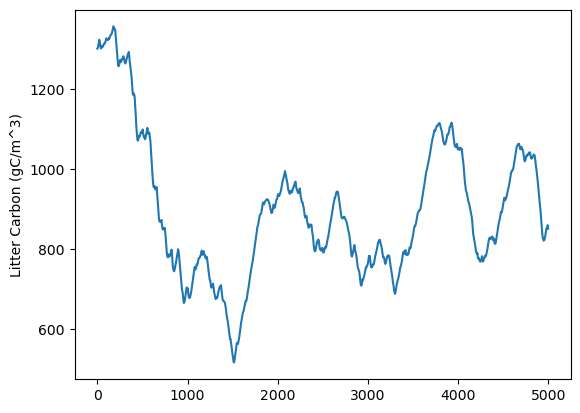

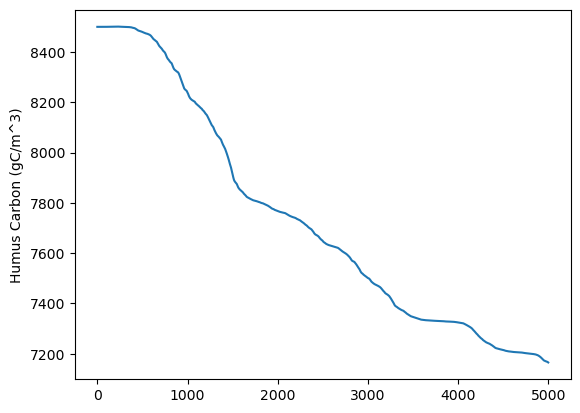

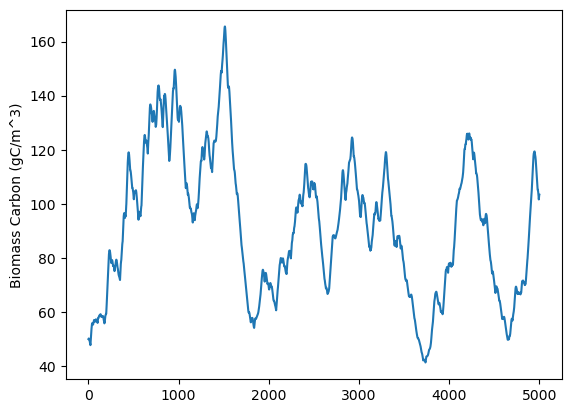

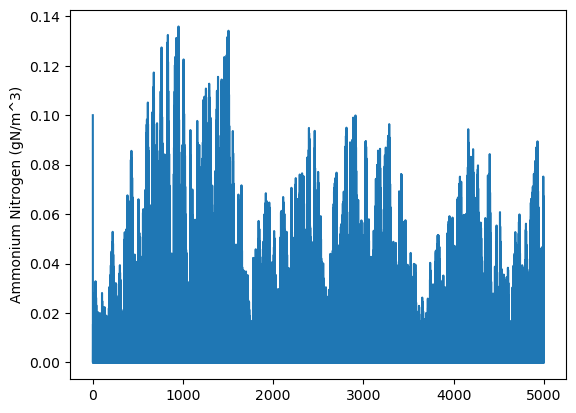

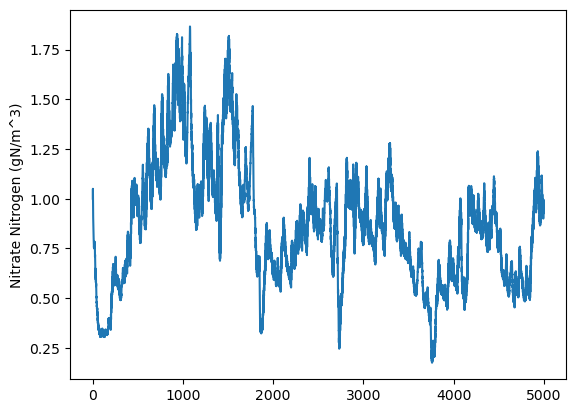

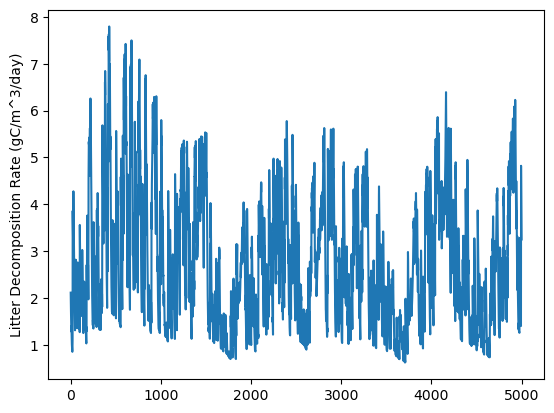

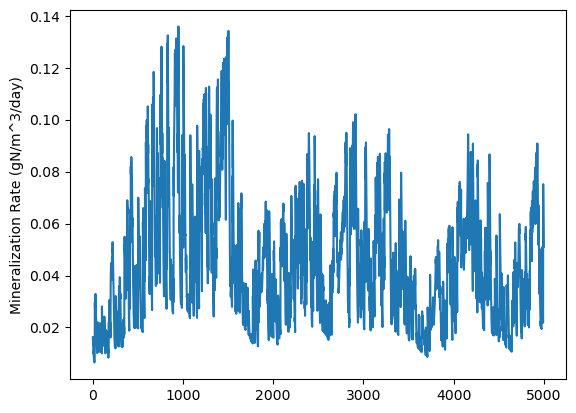

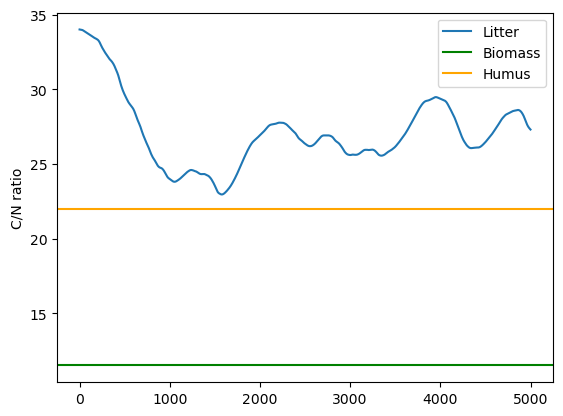

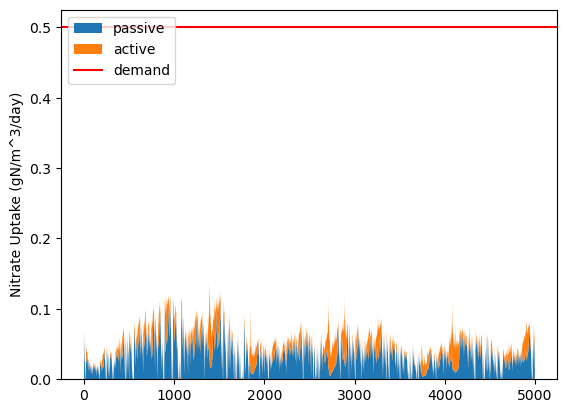

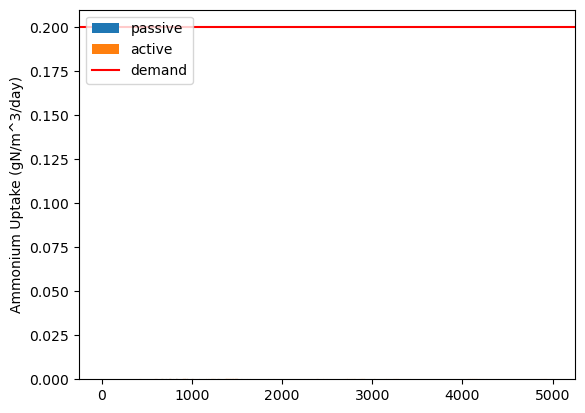

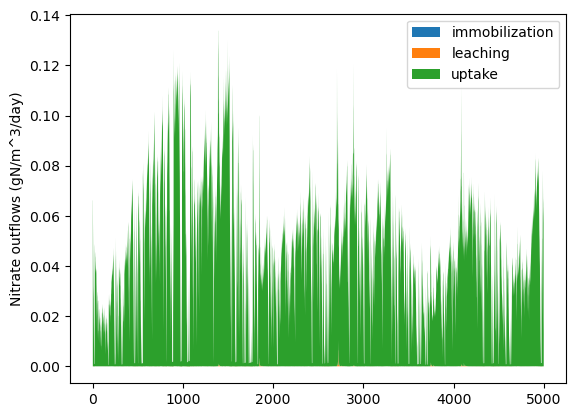

In [281]:
plt.figure()
plt.ylabel("Litter Carbon (gC/m^3)")
plt.plot(range(NUM_DAYS_TOTAL), litter_carbon_g_per_m3)
plt.figure()
plt.ylabel("Humus Carbon (gC/m^3)")
plt.plot(range(NUM_DAYS_TOTAL), humus_carbon_g_per_m3)
plt.figure()
plt.ylabel("Biomass Carbon (gC/m^3)")
plt.plot(range(NUM_DAYS_TOTAL), biomass_carbon_g_per_m3)
plt.figure()
plt.ylabel("Ammonium Nitrogen (gN/m^3)")
plt.plot(range(NUM_DAYS_TOTAL), ammonium_nitrogen_g_per_m3)
plt.figure()
plt.ylabel("Nitrate Nitrogen (gN/m^3)")
plt.plot(range(NUM_DAYS_TOTAL), nitrate_nitrogen_g_per_m3)
plt.figure()
plt.ylabel("Litter Decomposition Rate (gC/m^3/day)")
plt.plot(range(NUM_DAYS_TOTAL), litter_decomposition_rate_g_carbon_per_m3_per_day)
plt.figure()
plt.ylabel("Mineralization Rate (gN/m^3/day)")
plt.plot(range(NUM_DAYS_TOTAL), mineralization_rate_g_N_per_m3_per_day)
plt.figure()
plt.ylabel("C/N ratio")
plt.plot(range(NUM_DAYS_TOTAL), litter_cn_ratio, label="Litter")
plt.axhline(y=BIOMASS_CN_RATIO, label="Biomass", color="g")
plt.axhline(y=HUMUS_CN_RATIO, label="Humus", color="orange")
plt.legend()
plt.figure()
plt.ylabel("Nitrate Uptake (gN/m^3/day)")
plt.stackplot(range(NUM_DAYS_TOTAL), plant_passive_nitrate_uptake_rate_g_N_per_m3_per_day, plant_active_nitrate_uptake_rate_g_N_per_m3_per_day, labels=["passive", "active"])
plt.axhline(y=PLANT_NITRATE_DEMAND_GRAMS_N_PER_M3_PER_DAY, label="demand", color="red")
plt.legend(loc="upper left")
plt.figure()
plt.ylabel("Ammonium Uptake (gN/m^3/day)")
plt.stackplot(range(NUM_DAYS_TOTAL), plant_passive_ammonium_uptake_rate_g_N_per_m3_per_day, plant_active_ammonium_uptake_rate_g_N_per_m3_per_day, labels=["passive", "active"])
plt.axhline(y=PLANT_AMMONIUM_DEMAND_GRAMS_N_PER_M3_PER_DAY, label="demand", color="red")
plt.legend(loc="upper left")
plt.figure()
plt.ylabel("Nitrate outflows (gN/m^3/day)")
plt.stackplot(range(NUM_DAYS_TOTAL), nitrate_immobilization_rate_g_N_per_m3_per_day, nitrate_leaching_rate_g_N_per_m3_per_day, nitrate_uptake_rate_g_N_per_m3_per_day, labels=["immobilization", "leaching", "uptake"])
plt.legend(loc="upper right")